### Imports

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import re
from textblob import TextBlob

import nltk
nltk.download('stopwords')
nltk.download('punkt')


from nltk.stem import PorterStemmer, WordNetLemmatizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pandas as pd

from keras.models import Sequential
from keras.layers import Dense

from nltk import ngrams
from nltk import bigrams
from nltk import trigrams

from scipy.stats import pearsonr

from sklearn.neighbors import NearestNeighbors

import random

from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
### steps to build a CBOW model
- import and preprocess the text
- window the data to create x (context words) and y (center word)
- convert the context words and center word into vectors. each vector has the size of vocab length
- 

In [2]:
stop_words = set(stopwords.words('english'))

### import the data and store it as an array in the variable: corpus

In [3]:
data = pd.read_csv('blogtext_5k.csv')
corpus = data['text'].values

In [4]:
corpus[0]

'           Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.         '

In [5]:
lemmatizer = WordNetLemmatizer()

def preprocess(corpus):
    # loop through each document in the corpus
    for i in range(len(corpus)):
        # remove extra whitespace, lowercase all letters, and convert '\n' to ' '
        string = re.sub('\n',' ',corpus[i].strip().lower())
        # remove all characters which aren't letters or spaces
        string = re.sub('[^a-z ]','',string)

        # lemmatize all words
        string = " ".join([lemmatizer.lemmatize(word) for word in string.split()])
        corpus[i] = string
    
    return corpus

In [6]:
corpus = preprocess(corpus)

In [7]:
corpus[0]

'info ha been found page and mb of pdf file now i have to wait untill our team leader ha processed it and learns html'

### Here, we go through the full corpus taking a window size of 5.
### This means that we count the two words before and two words after as context words, and the center word is the word which we need to predict

In [8]:
def window(corpus, w_size):
    
    # window size has to be odd
    assert( w_size % 2 != 0 )

    x = [] # context words
    y = [] # center word
    
    for sent in corpus:

        sent = sent.split(' ')
        i = 0
        mid = int(w_size / 2)

        while i <= len(sent) - w_size:
            target = sent[i+mid]
            context = sent[i:i+mid] + sent[i+mid+1:i+w_size]

            x += context
            y.append(target)
            i += 1
    return x,y


In [9]:
x,y = window(corpus, 5)

In [11]:
# initizalize and fit the vectorizer
vec = CountVectorizer(ngram_range=(1, 1), min_df=4)
vec.fit(corpus)

CountVectorizer(min_df=4)

In [12]:
len(x), len(y)

(2906472, 726618)

### x is 4 times the length of y because for each center word, we have 4 context words. We will reshape the inputs in the generator function below

### a custom generator function is built to reduce memory. This generator will be fed to the keras model

In [13]:
def gen():
    batch_size = 100
    batch_size_2 = 400
    
    i = 0
    j = 0
    while True:
        # vectorize the context words and center word
        features = vec.transform(x[j:j+batch_size_2])
        labels = vec.transform(y[i:i+batch_size])
        
        # reshape the context words to have 4 words per datapoint
        features = features.toarray().reshape(
            int(features.shape[0]/4),4,-1).mean(axis=1)
        
        
        yield features, labels.todense()
        
        
        i += batch_size
        j += batch_size_2
        if i + batch_size > features.shape[0]:
            i = 0
            j = 0

In [14]:
len(vec.vocabulary_)

8492

### create and fit the ANN

In [15]:
gen1 = gen()

model = Sequential()
model.add(Dense(80, input_dim=len(vec.vocabulary_), activation='relu'))
model.add(Dense(len(vec.vocabulary_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(gen1, steps_per_epoch=int(len(y)/100), verbose=True, epochs=6, batch_size=100)

Epoch 1/6
7266/7266 [==============================] - 231s 32ms/step - loss: 1.7245 - accuracy: 0.3789
Epoch 2/6
7266/7266 [==============================] - 231s 32ms/step - loss: 1.3783 - accuracy: 0.4099
Epoch 3/6
7266/7266 [==============================] - 230s 32ms/step - loss: 1.3090 - accuracy: 0.3986
Epoch 4/6
7266/7266 [==============================] - 231s 32ms/step - loss: 1.2974 - accuracy: 0.3957
Epoch 5/6
7266/7266 [==============================] - 232s 32ms/step - loss: 1.2831 - accuracy: 0.3918
Epoch 6/6
7266/7266 [==============================] - 232s 32ms/step - loss: 1.2516 - accuracy: 0.3868


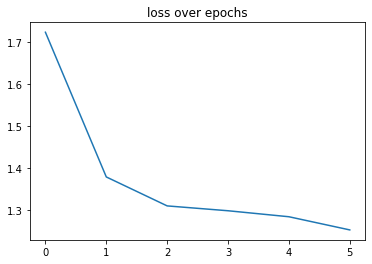

In [16]:
plt.plot(history.history['loss'])
plt.title('loss over epochs')
plt.show()

In [17]:
# take the weights of the first layers as the embeddings
embeddings = model.layers[0].weights[0].numpy()

In [18]:
print(f'embedings.shape: {embeddings.shape}')
print(f'len(vec.vocabulary_): {len(vec.vocabulary_)}')

embedings.shape: (8492, 80)
len(vec.vocabulary_): 8492


### we can test the quality of the embeddings by sampling some words and listing other words with similar embeddings

In [19]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric='l2').fit(embeddings)

In [20]:
vocab = vec.vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}

In [39]:
# get 30 random words in the vocabulary
words = []

for i in range(30):
    word = random.choice(list(vocab))
    
    words.append(word)
    
    idx = vocab[word]
        
    embedding = embeddings[idx].reshape(1,-1)
    
    distances, indices = nbrs.kneighbors(embedding)
    
    # remove the first word since it's always the same word which we're trying to get the neigbhors of
    indices = indices[0][1:]
    
    print(
        word,
        ':',
        *[inv_vocab[w] for w in indices]
    )
    

hiding : dip wound entitled
mailbox : permit owing shot
opted : flirting soil slab
slipped : age shark hack
doe : jefferson staircase outta
esp : simply draped editor
tender : meat dispute seen
require : borrow separated tart
meant : remark rack immature
regarded : humble voucher gah
pope : warped giddy cynical
did : yes sisterinlaw symbol
reminded : kick principal dummy
hooked : teacher block commie
hottie : ski rolled relief
son : however eternity halfway
touched : grilled blessing hmmmmm
expected : justice monthly deep
dimension : coveted gotta scifi
arrogant : carried company screwing
cellphone : shade distract sydney
facet : invented government modeling
booty : worldly his dare
black : referring line yo
patrol : laden essential wildly
corner : energy skim flush
junior : correctly landing being
wondering : ironic spreading tiger
lecture : guided glow truth
next : milpitas offend series


### based on the above results, the quality of the embeddings does not seem very high
### possible improvements include: 
- using a much larger corpus. this is a very small corpus for training such a model
- larger vector embeddings
- training the data on more epochs
- better preprocessing of the corpus such as autocorrecting misspelled words

# ------------------------------------------------------------------------------------------------------------

### testing a ready Word2Vec model on the same corpus

In [49]:
corpus_as_list = [sentence.split() for sentence in corpus]

In [50]:
# fitting the word2vec model
model = Word2Vec(sentences=corpus_as_list, size=80, window=5, min_count=1, workers=4)

In [52]:
# testing word2vec on the same words as tested above
for word in words:
    vector = model.wv[word]  # get numpy vector of a word
    sims = model.wv.most_similar(word, topn=10)  # g
    
    print(
        word,
        ':',
        *[w[0] for w in sims[0:3]])

hiding : connected race except
mailbox : pant hair throat
opted : buck nurturing prop
slipped : returned flew hit
doe : doesnt meant exactly
esp : english sucked charles
tender : oakland university quarterly
require : extend appear increase
meant : rude comfortable impossible
regarded : urban canadian sealed
pope : envelope spokesman eugene
did : shouldnt sux clumsily
reminded : crazy noticing mention
hooked : hook finger lay
hottie : baked agains spoiling
son : father neck kaptur
touched : dean kerry displayed
expected : unfortunately serious lucky
dimension : misuse term importantly
arrogant : presidential rat carefully
cellphone : form simplicity inspiration
facet : moral devoid emotion
booty : sprinkling barking headset
black : chain ice brown
patrol : quietly colin removed
corner : side area bus
junior : grandmother defense empty
wondering : exactly kidding yes
lecture : september foot chair
next : over every sunday
